| <p style="text-align: left;">Name</p>               | Matr.Nr. | <p style="text-align: right;">Date</p> |
| --------------------------------------------------- | -------- | ------------------------------------- |
| <p style="text-align: left">Lion DUNGL</p> | 01553060 | 03.06.2020                            |

<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 8 (Assignment) -- Introduction to Reinforcement Learning -- Part I </h2>

<b>Authors</b>: Brandstetter, Schäfl <br>
<b>Date</b>: 18-5-2020

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies 
to all code within this file.

<b>Copyright statement</b>: <br>
This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h2>Exercise 0</h2>
Before tackling all those exciting tasks of this notebook, the neccessary Python modules need to be loaded. Have a look at the notebook discussed during the lecture, and import the same modules:

In [1]:
import u8_utils as u8
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from typing import Any, Dict, Tuple

# Set Seaborn plotting style.
sns.set()

<h3 style="color:rgb(0,120,170)">Module versions</h3>
As mentioned in the introductiory slides, specific minimum versions of Python itself as well as of used modules is recommended.

In [2]:
u8.check_module_versions()

Installed Python version: 3.7 (✓)
Installed matplotlib version: 3.1.3 (✓)
Installed Pandas version: 1.0.3 (✓)
Installed Seaborn version: 0.10.1 (✓)
Installed OpenAI Gym version: 0.17.2 (✓)


<h2>Exercise 1</h2>

All exercises in this assignment are referring to the <i>FrozenLake-v0</i> environment of <a href="https://gym.openai.com"><i>OpenAI Gym</i></a>. This environment is descibed according to its official <a href="https://gym.openai.com/envs/FrozenLake-v0/">OpenAI Gym website</a> as follows:<br>
<cite>Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.</cite>


There are <i>four</i> types of surfaces described in this environment:
<ul>
    <li><code>S</code> $\rightarrow$ starting point (<span style="color:rgb(0,255,0)"><i>safe</i></span>)</li>
    <li><code>F</code> $\rightarrow$ frozen surface (<span style="color:rgb(0,255,0)"><i>safe</i></span>)</li>
    <li><code>H</code> $\rightarrow$ hole (<span style="color:rgb(255,0,0)"><i>fall to your doom</i></span>)</li>
    <li><code>G</code> $\rightarrow$ goal (<span style="color:rgb(255,0,255)"><i>frisbee location</i></span>)</li>
</ul>


If not already done, more information on how to <i>install</i> and <i>import</i> the <code>gym</code> module is available in the lecture's notebook.

In [3]:
import gym

from gym.envs.toy_text import FrozenLakeEnv

<h3 style="color:rgb(0,120,170)">States and actions</h3>
Experiment with the <i>FrozenLake-v0</i> environment as discussed during the lecture and explained in the accompanying notebook.
<ul>
    <li>Create a <i>FrozenLake</i> environment with either a call to the constructor <code>FrozenLakeEnv()</code> or via a general factory function <code>gym.make(r'FrozenLake-v0').env</code>.
    <li>For reproducability reasons, always set the <i>random seed</i> if working with randomness (like drawing from a distribution using a pseudo random number generator). The <code>u8_utils.py</code> file provides a neat helper function <code>set_seed</code> for this very purpose.</li>
</ul>

In [4]:
FrozenLake = FrozenLakeEnv()
u8.set_seed(FrozenLake, 42)

As a next step, and as the environment might be unknown to some, visualise the current state.
<ul>
    <li>Visualise the current <i>FrozenLake</i> environment in a human-readable way.</li>
    <li>Print the identifier of the current state using the appropriate property of the environment.</li>
</ul>

In [5]:
FrozenLake.render(mode=r'human')
current_state_id = FrozenLake.s
print(f'\nCurrent State ID: {current_state_id}')


SFFF
FHFH
FFFH
HFFG

Current State ID: 0


The current position of the <i>disc retrieving</i> entity is displayed as a filled <span style="color:rgb(255,0,0)"><i>red</i></span> rectangle.

As we want to tackle this problem using our renowned <i>random search</i> approach, we have to analyse its applicability beforehand. Hence, the number of possible <i>actions</i> and <i>states</i> is of utter importance, as we don't want to get lost in the depth of combinatorial explosion.
<ul>
    <li>Query the amount of <i>actions</i> using the appropriate peoperty of the lake environment.</li>
    <li>Query the amount of <i>states</i> using the appropriate property of the lake environment.</li>
</ul>

In [6]:
n_actions = FrozenLake.action_space.n
n_states = FrozenLake.observation_space.n
print(f'Amount of actions: {n_actions}\nAmount of states: {n_states}')

Amount of actions: 4
Amount of states: 16


<h3 style="color:rgb(0,120,170)">Rewards</h3>
Remember that each <i>action</i> triggers a <i>reaction</i> (at least in the domain of Reinforcement Learning), in this case in the form of a <i>reward</i> or a <i>penalty</i>. As the definition of both, the former as well as the latter would be redundant, only the former is kept, the <i>reward</i>. The latter, the <i>penalty</i>, is simply a <i>negative reward</i>. According to the description of the <a href=https://gym.openai.com/envs/FrozenLake-v0/>environment's website</a>:<br><br>
<cite>The episode ends when you reach the goal or fall in a hole. You receive a reward of $1$ if you reach the goal, and zero otherwise.</cite><br><br>
Hence in the current setting, only <i>non-negative</i> rewards are issued, and <i>no</i> penalty per se. The goal of our <i>agent</i> is to maximise the reward by still solving the task. in this setting, this would translate to the following premises:
<ul>
    <li>Reach the goal (i.e. pickup the frisbee).</li>
    <li>Do not undertake involuntary dives.</li>
    <li>Try to keep some distance to holes, as the ice is slippery.</li>
</ul>

The mapping <i>state</i>$\rightarrow$<i>action</i> for all possible combinations of <i>state</i> and <i>actions</i> is defined in a <i>reward table</i>. Investigate the reward tablewith respect to the <i>current state</i> of our instantiated <i>FrozenLake</i> environment.

In [7]:
FrozenLake.P[current_state_id]

{0: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 4, 0.0, False)],
 1: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 4, 0.0, False),
  (0.3333333333333333, 1, 0.0, False)],
 2: [(0.3333333333333333, 4, 0.0, False),
  (0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)],
 3: [(0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)]}

Each entry of the <i>reward table</i> contains a dictionary of the form <code>A: [3 x (B, C, D, E)]</code>.

<h3 style="color:rgb(208,90,80)">Tasks</h3>

<ul>
    <li><span style="color:rgb(208,90,80)">Think about the different <i>actions</i>. Which ones might be available?</span></li>
    <li><span style="color:rgb(208,90,80)">Think about the different <i>states</i>. Which ones might be possible?</span></li>
    <li><span style="color:rgb(208,90,80)">Think about the structure of the <i>reward table</i>. Why are there <i>three</i> elements per dictionary entry, instead of <i>one</i> like the <i>Taxi</i> environment defined?</span></li>
</ul>

# Actions
As found out before there are 4 different possible actions. I think those actions are:
- (0) Move Left 
- (1) Move Down 
- (2) Move Right 
- (3) Move Up 

# States
There are 4 times 4 fields where the agent can be, therefore there are 4 time 4 = 16 different possible locations and therefore states. I think that the state IDs are assigned by always taking one step to the right: 
- In state (0) the agent is located in the upper left corner
- In state (1) the agent is located 1 step to the right of its location in state (0)
- and so on...

Moreover it's worth mentioning that after performing particular actions in particular states like action (0) in state (0), the location of the agent and therefore the state mustn't necessarily change. E.g. When trying to perform action (0), one step up, and this action is exectued like planned (--> second row of dictionary entry is relevant), the location and therefore the state doesn't change because there's no field above the initial one. The same is with action (3) in state (0).

# Taking action
When taking a certain action, it is not for sure that exactely this action will be executed...the ice is very slippery! Therefore, when choosing a specific action (n), the probability of performing this step as planned (e.g. actually taking one step to the left when choosing action (1)) is only 1/3 as can be seen in the middle row of each dictionary entry. There's a 2/3 probability of slipping. Then either one of two actions alongside the other axis (e.g. when the chosen action is (0) left, there's a 2/3 probability that action (1) Down or (3) Up happens) is executed, each with the same probability of 1/3, as can be seen in the first and third row of each dictionary entry.
<br>So let's take action (2) for example:
- The probability of performing an actual move to the right is 1/3 (second row in reward table at dictionary entry 2)
- The probability of performing a move down is 1/3 (first row in reward table at dictionary entry 2)
- The probability of performing a move up is 1/3 (third row in reward table at dictionary entry 2)

<h2>Exercise 2</h2>

Previously, we talked about solving this task in a na&#xEF;ve way by simply applying <i>brute force</i>: using <i>random search</i>. In the meantime we analysed the <i>action</i> as well as the <i>state space</i> and came to the conclusion, that such an approach is more than feasible. To repeat the outline of such an approach:
<ul>
    <li><code>I</code> $\rightarrow$ choose a random <i>action</i> with respect to the <i>current</i> state.</li>
    <li><code>II</code> $\rightarrow$ execute previously chosen <i>action</i> and transition into a <i>new</i> state.</li>
    <li><code>III</code> $\rightarrow$ if the episode is finished, but the goal not reached, <i>reset</i> the position of the <i>disc retrieving entity</i>.</li>
</ul>

This procedure is repeated as long as the task is not solved or a defined maximum of steps is reached, whatever triggers first (<code>IV</code>). Adapt the function <code>apply_random_search</code> as discussed during the lecture. Mark the corresponding sections of the code using <code>I</code>, <code>II</code>, <code>III</code> and <code>IV</code>. Note that our <i>random search</i> is <i>not</i> guaranteed to find  the solution of a task in <i>finite time</i>, hence an upper border on the <i>runtime</i> is often applied as a safety net (in our case the <i>number of allowed steps</i>).

In [8]:
def apply_random_search(env: FrozenLake, max_num_steps: int) -> Tuple[int, int, int, Dict[str, Any]]:
    """
    Solve specified environment by applying random search.
    
    :return: amount of steps performed, number of involuntarily taken dives, final reward and captured frames
    """
    num_steps, final_reward, num_dives = 0, 0, 0
    captured_frames = []
    
    # <IV>: repeat the procedure as long as the task is not solved or a defined maximum of steps is reached.
    done = False
    while not done:
        
        # <I>: choose a random action with respect to the current state.
        current_action = env.action_space.sample()

        # <II>: execute previously chosen action and transition into a new state.
        current_state, current_reward, done, info = env.step(current_action)
     
        # <III>: if the episode is finished, but the goal not reached, reset the position of the disc retrieving entity.
        if done and env.s != 15:
            num_dives += 1
            env.reset()
            done = False
            
        elif done and env.s == 15:
            final_reward = 1
            
        num_steps += 1
        
        # Save rendering of current state.
        captured_frames.append({
            r'frame': env.render(mode=r'ansi'),
            r'state': current_state,
            r'action': current_action,
            r'reward': current_reward
        })
        
        # <IV>: abort the procedure when a defined maximum of steps is reached.
        if num_steps == max_num_steps:
            break
        
    return num_steps, num_dives, final_reward, captured_frames

Now everything is setup and the <i>random search</i> procedure is eagerly waiting to explore the exciting world of <i>FrozenLake-v0</i> (the <i>Taxi-v3</i> world was a less exciting than thought)!
<ul>
    <li>Again for reproducability reasons, the <i>random seed</i> is set, in this case to $42$. The <code>u8_utils.py</code> file provides a neat helper function <code>set_seed</code> for this very purpose.</li>
    <li>To actually start the random search, the previously defined function <code>apply_random_search</code> is of great help.</li>
    <li>At least randomly search for $10\ 000$ steps.</li>
</ul>

To get a better feeling about the <i>exploration</i>, we're reporting the amount of steps performed as well as the amount of involuntary dives. Let's get excited!

In [9]:
u8.set_seed(environment=FrozenLake, seed=42)
num_steps, num_dives, final_reward, captured_frames = apply_random_search(env=FrozenLake, max_num_steps=100000)
print(f'{num_steps} steps and {num_dives} involuntary dive(s) taken during randomly searching the goal, with a final reward of {final_reward}.')

260 steps and 32 involuntary dive(s) taken during randomly searching the goal, with a final reward of 1.


Actually, the result looks quite good, especially when comparing it with the random searches conducted in the <i>Taxi</i> environment. Let's animate the searching procedure (use a <code>delay</code> of $0.1$ for better visualisation):

In [10]:
u8.animate_environment_search(frames=captured_frames, verbose=True, delay=0.1)

  (Right)
SFFF
FHFH
FFFH
HFFG

Step No.: 260
State ID: 15
Action ID: 2
Reward: 1.0


<h3 style="color:rgb(208,90,80)">Tasks</h3>

<ul>
    <li><span style="color:rgb(208,90,80)">Why is the result of randomly searching the <i>FrozenLake-v0</i> environment by far better than randomly searching the <i>Taxi</i> environment?</span></li>
    <li><span style="color:rgb(208,90,80)">Are the results transferable to <i>bigger</i> lakes? Argument your answer.</span></li>
</ul>

# Answer 1
I think that the results of randomly searching FrozenLake-v0 are far better than those of randomly searching the Taxi environment because of the great difference between the possible states of the FrozenLake environment (only 16) and those of the Taxi environment (500).

# Answer 2
I think no. When comparing a big FrozenLake with 500 possible states with a Taxi environment with the same number of states, I assume that it takes around the same amount of steps to reach the goal on the FrozenLake and in the Taxi environment.

- On the FrozenLake there's the possibility to fall in a hole; then the whole process has to start again, which costs steps. This isn't the case in the Taxi environment. --> num_steps_lake > num_steps_taxi
- There's a greater number of possible actions to choose from in the Taxi environment, as a result the chance to pick the correct action in a random aproach is only 1/6 and therefore smaller than in the FrozenLake environment (only 4 possible actions --> chance 1/4 to pick the right one) --> num steps_lake = num_steps_taxi
- BUT on the FrozenLake we have the special situation that the agent can slip. Then another action than the chosen one is executed. Actually the chance that the desired action is really executed is only 1/3. Therefore the overall chance of performing the right action is 1/4 * 1/3 = 1/12 which is less than the chance in the taxi environment --> num_steps_lake > num_steps_taxi
- BUT 2.0 because of the slippery lake there's the chance that the agent performs the right step even though he hasn't chosen it. To be precise, the probability to perform the right step is 1/4 * 1/3 * 3 = 1/4 (let's assume the right step is moving left; there are three different possible actions which can lead to this step: action (0), action (1) and action (3) --> probability of choosing one of those actions is 1/4 * 3. But when choosing one of those three actions, there's only a probabiltity of 1/3 that a step to the left is performed --> probability of choosing one of the three actions AND executing the right step: (1/4 * 1/3) * 3). Therefore, the overall probability of taking the right step in the FrozenLake environment is 1/4, which is greater than the one in the taxi environment (1/6). --> num_steps_lake = num_steps_taxi 

<h2>Exercise 3</h2>

To drill down on the drawbacks of plain <i>random search</i>, we are designing the following experimental setup:
<ul>
    <li>Repeat the previous <i>random search</i> procedure $100$ times.</li>
    <li>Aggregate the results of each run for later analysis.</li>
    <li>Visualise the aggegrated results using e.g. <i>box-</i> and <i>swarm-plots</i>.</li>
</ul>
Once again, we are setting the <i>random seed</i>, but take care of setting it <i>outside</i> the loop, otherwise the same result is reported with each iteration (and an aggregation of the results would not give us any more insights).

In [11]:
def visualize_random_approach(env, seed, max_num_steps):  
    u8.set_seed(environment=env, seed=seed)
    num_steps_total, num_dives_total, final_reward_total = [], [], [] 
    num_repetitions = 100

    # Collect information over multiple repetitions.
    for repetition in range(num_repetitions):
        num_steps, num_dives, final_reward, _ = apply_random_search(env=env, max_num_steps=max_num_steps)
        num_steps_total.append(num_steps)
        num_dives_total.append(num_dives)
        final_reward_total.append(final_reward)
        env.reset()

    # Combine collected information to a data frame for further downstream analysis.
    collected_experiment_info = pd.DataFrame(zip(num_steps_total, num_dives_total, final_reward_total), columns=(r'Steps performed', r'Dives taken', r'Final rewards')) if 0 in final_reward_total else pd.DataFrame(
        zip(num_steps_total, num_dives_total), columns=(r'Steps performed', r'Dives taken'))
    
    fig, ax = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(20, 7))
    ax[0, 0].set_xscale(r'symlog')
    fig.suptitle(f'{str(env)}, initial seed = {seed}, maximal steps = {max_num_steps}')
    _ = sns.boxplot(data=collected_experiment_info, ax=ax[0, 0], orient=r'h')
    _ = sns.swarmplot(data=collected_experiment_info, ax=ax[0, 0], color=r'0.3', orient=r'h')

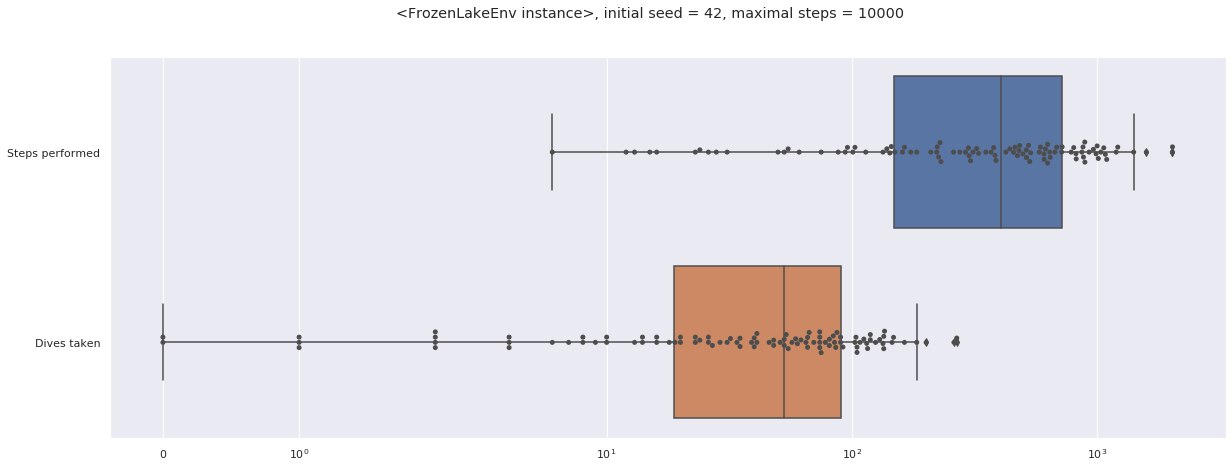

In [12]:
visualize_random_approach(env=FrozenLake, seed=42, max_num_steps=10000)

<h3 style="color:rgb(208,90,80)">Tasks</h3>

<ul>
    <li><span style="color:rgb(208,90,80)">Try out different <code>maximal steps</code> and <code>initial seeds</code> (still repeating the random search procedure $100$ times). Do the results differ?</span></li>
    <li><span style="color:rgb(208,90,80)">Which kind of information could a potential <i>Reinforcement Learning</i> method incorporate?</span></li>
</ul>

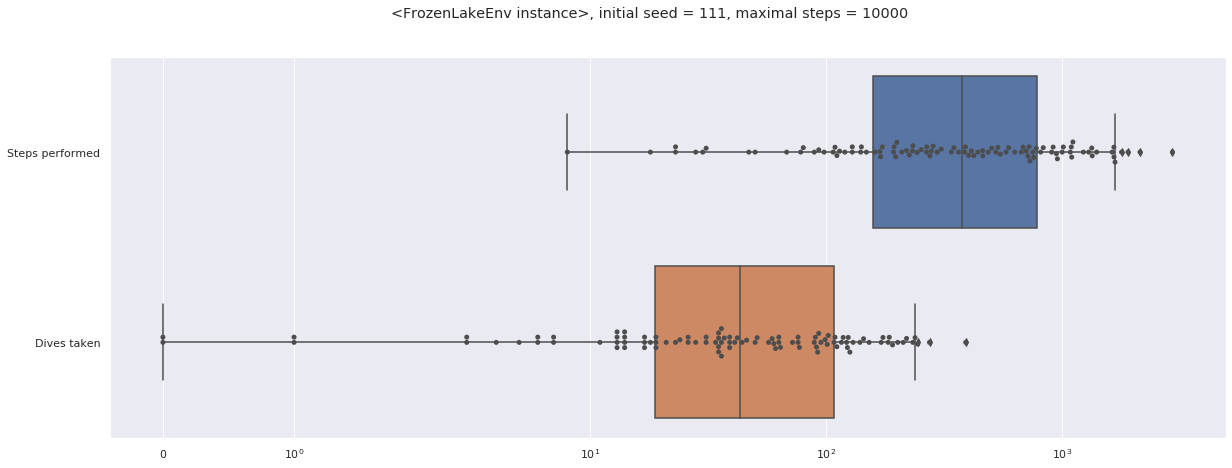

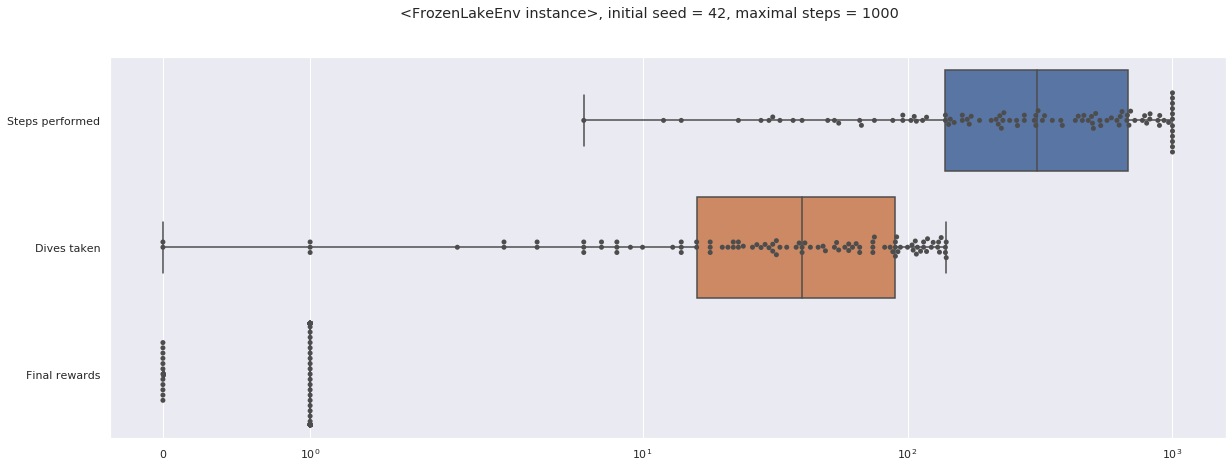

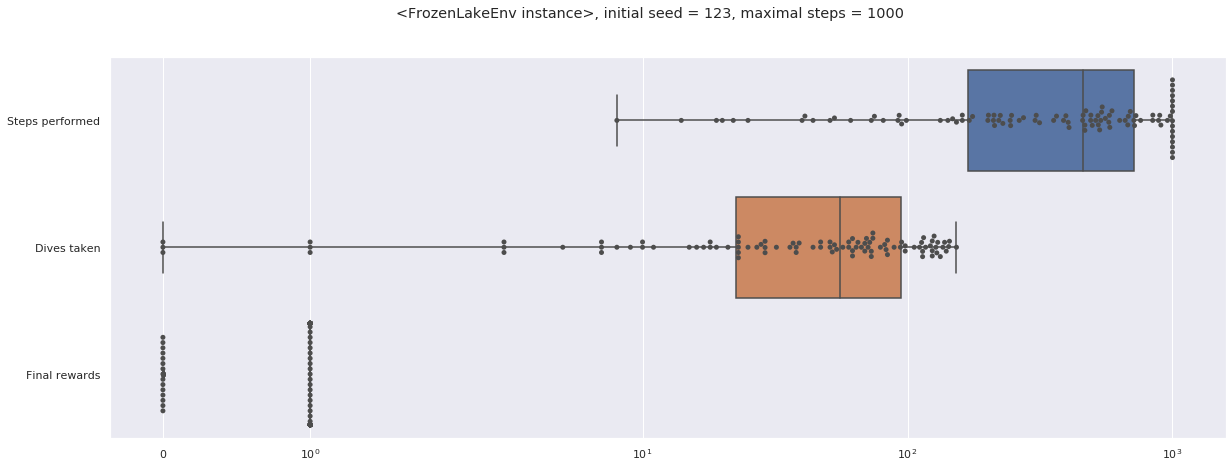

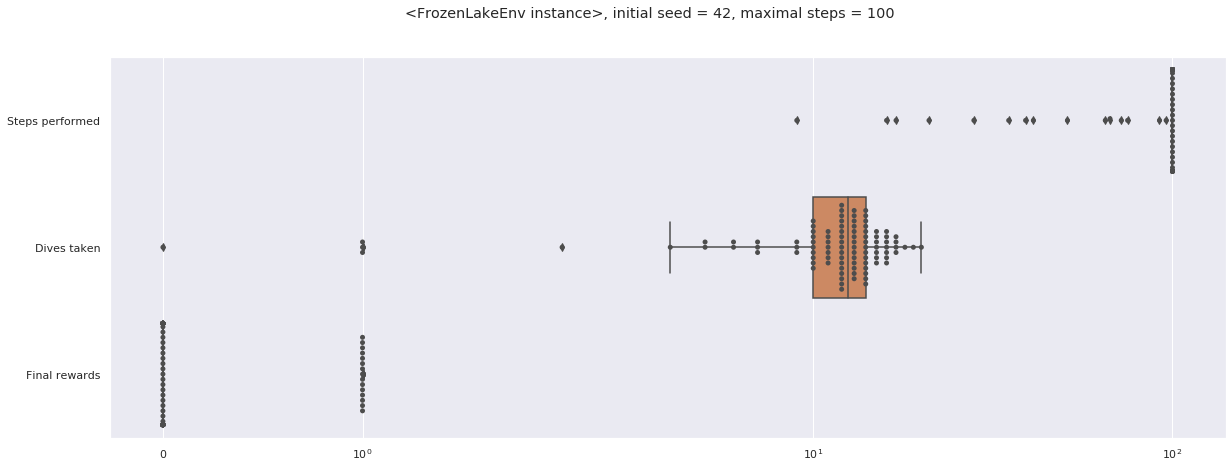

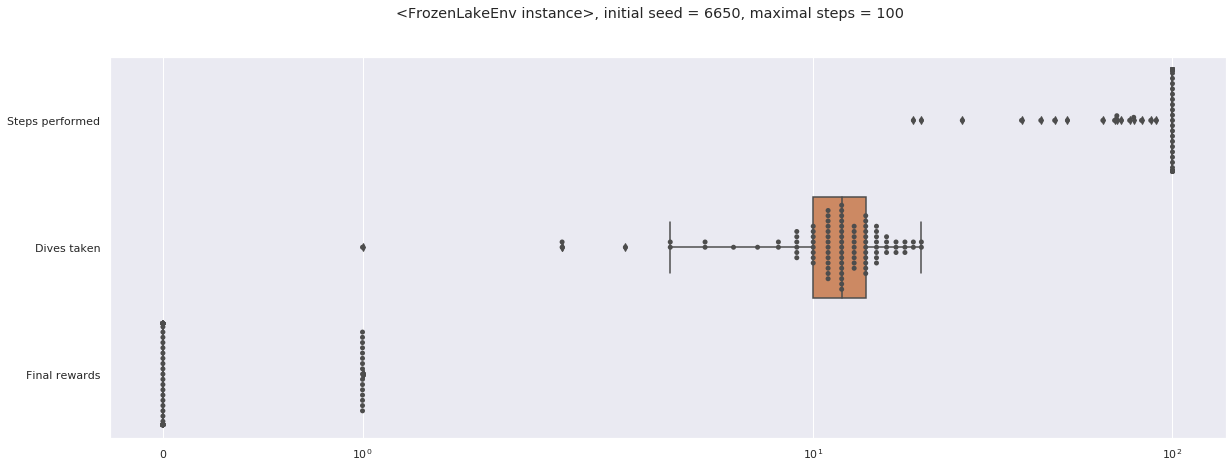

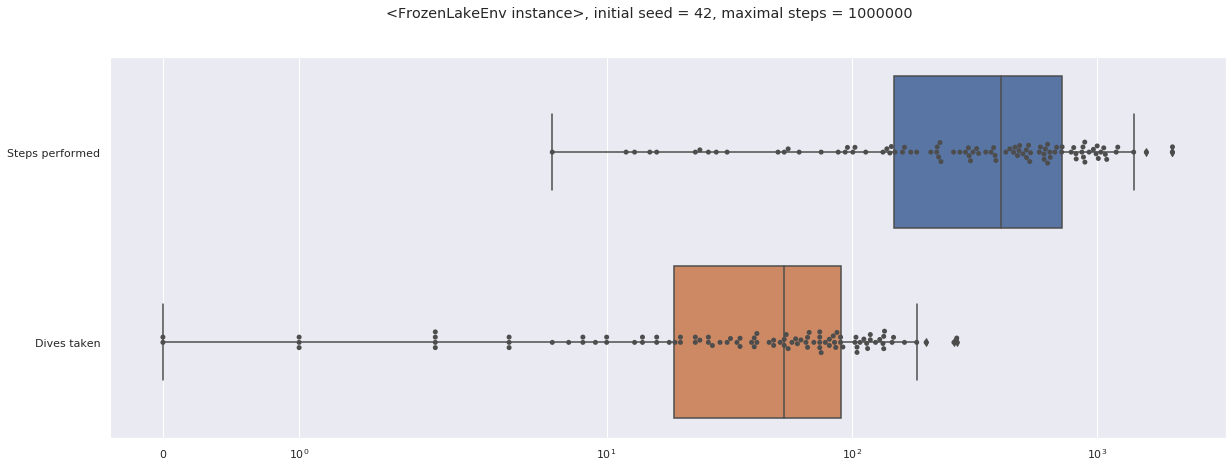

In [13]:
visualize_random_approach(env=FrozenLake, seed=111, max_num_steps=10000)
visualize_random_approach(env=FrozenLake, seed=42, max_num_steps=1000)
visualize_random_approach(env=FrozenLake, seed=123, max_num_steps=1000)
visualize_random_approach(env=FrozenLake, seed=42, max_num_steps=100)
visualize_random_approach(env=FrozenLake, seed=6650, max_num_steps=100)
visualize_random_approach(env=FrozenLake, seed=42, max_num_steps=1000000)

# Answer 1
Yes, the results do differ, though when changing the initial seed the results change only slightly wheras when changing the maximal number of steps there's a greater difference.

## changing the initial seed
When changing the initial seed, there's not such a great difference in the results. The distribution of the boxplots and the data points stays more or less the same.

## changing the maximal number of steps
This results in a greater difference, but only when the number of steps is decreased (with respect to the initial value of 10000). There's no difference when it is increased. Reason for this is that from a certain value on, the environment is always solved. This can be seen when observing the absence of the third plot 'final rewards' in a few figures (with max_num_steps = [1000000, 10000]), which means that the final reward is 1 for every repetition. Therefore, the maximum number of steps in these cases is so high, that the agent always can use enough steps to get to the goal. It doesn't make a difference if the maximum number of steps is e.g. 2 times higher; the environment can already be solved every time.

This is not the case when decreasing the maximum number of steps. From a certain value on, there will be repetitions where max_num_steps isn't high enough to solve the environment. The repetition is aborted before the goal can be reached. Therefore, the final reward isn't always one (see third plot in figures with max_num_steps = [100, 1000]).

# Answer 2

A potential RL method could incorporate...
- the possible right steps it could take (steps that lead to a F field and/or steps that lead to a F field AND reduce the distance to the goal).
- the possibility with which a certain step can be performed with a particular action.
- which action has the highest probability of resulting in a step that leads the agent to a F field.